# Using MIMIC raw records

### Import diseases in MIMIC

In [10]:
import pandas as pd

diseases=pd.read_csv("/kaggle/input/mimic-iv-diagnoses-d-icd/d_icd_diagnoses.csv")
diseases.dropna(inplace=True,subset="icd_code")

fs=125 # sampling freq in Hz

### Getting diagnosis codes for all diseases of interest

In [11]:
icd_codes=[]
icd_codes.append(diseases.loc[diseases["long_title"].str.contains("arrhythmia"),"icd_code"].values)
icd_codes.append(diseases.loc[diseases["long_title"].str.contains("fibrillation"),"icd_code"].values)
icd_codes.append(diseases.loc[diseases["long_title"].str.contains("tachycardia"),"icd_code"].values)
icd_codes.append(diseases.loc[diseases["long_title"].str.contains("bradycardia"),"icd_code"].values)
icd_codes = [
    x
    for xs in icd_codes
    for x in xs
]
icd_codes

['I470',
 'I49',
 'I498',
 'I499',
 '42731',
 '42741',
 'I48',
 'I480',
 'I481',
 'I4811',
 'I4819',
 'I482',
 'I4820',
 'I4821',
 'I489',
 'I4891',
 'I490',
 'I4901',
 '4270',
 '4271',
 '4272',
 '77982',
 'G90A',
 'I47',
 'I471',
 'I472',
 'I4720',
 'I4729',
 'I479',
 'P2911',
 '77981',
 'P2912']

### Import patients in MIMIC

In [12]:
patients=pd.read_csv("/kaggle/input/mimic-iv-diagnosis-icd/diagnoses_icd.csv")
patients.dropna(inplace=True,subset="icd_code")
patients

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9
...,...,...,...,...,...
6364483,19999987,23865745,7,41401,9
6364484,19999987,23865745,8,78039,9
6364485,19999987,23865745,9,0413,9
6364486,19999987,23865745,10,36846,9


### Search for a patient by subject ID
useful when you find that subject in another sub-dataset from MIMIC and you want to use both.

In [13]:
patients.loc[patients["subject_id"]==10014354]

,subject_id,hadm_id,seq_num,icd_code,icd_version
9331,10014354,20900955,1,R410,10
9332,10014354,20900955,2,R51,10
9333,10014354,20900955,3,M533,10
9334,10014354,20900955,4,M25512,10
9335,10014354,20900955,5,E119,10
...,...,...,...,...,...
9887,10014354,29780751,19,Z950,10
9888,10014354,29780751,20,R002,10
9889,10014354,29780751,21,M7989,10
9890,10014354,29780751,22,E669,10


### Merge patients with diseases

In [14]:
diseases['icd_code']=diseases['icd_code'].astype(str)
patients['icd_code']=patients['icd_code'].astype(str)
merged=patients.merge(diseases,on='icd_code',how='left')
merged.loc[merged["subject_id"]==10014354,"long_title"].values

array(['Disorientation, unspecified', 'Headache',
       'Sacrococcygeal disorders, not elsewhere classified',
       'Pain in left shoulder',
       'Type 2 diabetes mellitus without complications',
       'Chronic lymphocytic leukemia of B-cell type not having achieved remission',
       'Hypertensive heart disease with heart failure',
       'Heart failure, unspecified',
       'Personal history of transient ischemic attack (TIA), and cerebral infarction without residual deficits',
       'Presence of cardiac pacemaker', 'Hyperlipidemia, unspecified',
       'Unspecified atrial fibrillation',
       'Long term (current) use of antithrombotics/antiplatelets',
       'Long term (current) use of insulin', 'Other chest pain',
       'Anxiety disorder, unspecified',
       'Malignant neoplasm of left testis, unspecified whether descended or undescended',
       'Atherosclerotic heart disease of native coronary artery without angina pectoris',
       'Presence of coronary angioplasty impl

We can now look up diseases of a specific patient

In [15]:
arrhythmia_patients=patients.loc[patients["icd_code"].isin(icd_codes),"subject_id"].unique()

### Check if a patient exists in arrhythmia patients
Arrhythmia patients defined by having any of the specified keywords in their diagnoses.

In [16]:
10014354 in arrhythmia_patients

True

# Using cleaned MIMIC Perform AF dataset
This is a sub-dataset found online (mimic-perform-af-dataset) concerned only with atrial fibrillation.

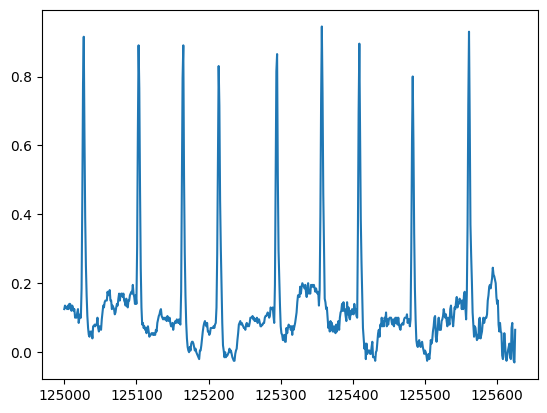

In [124]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

# WITH AF
data=pd.read_csv("/kaggle/input/mimic-perform-af-dataset/mimic_perform_af_csv/mimic_perform_af_csv/mimic_perform_af_016_data.csv")
start=(1000*fs)
signal=data["ECG"].loc[start:start+5*fs]
peaks, _=find_peaks(signal, height=1, threshold=0.001, distance=0.2*fs)
plt.plot(signal.index, signal)
#plt.scatter(np.add(peaks,start), [1]*len(peaks), color='r')
plt.show()

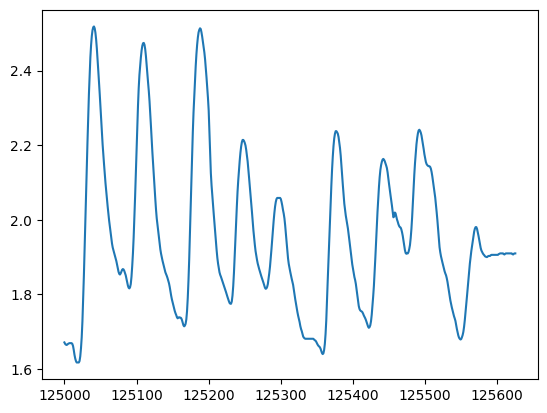

In [125]:
plt.plot(data.index[start:start+(5*fs)+1],data["PPG"].loc[start:start+(5*fs)])

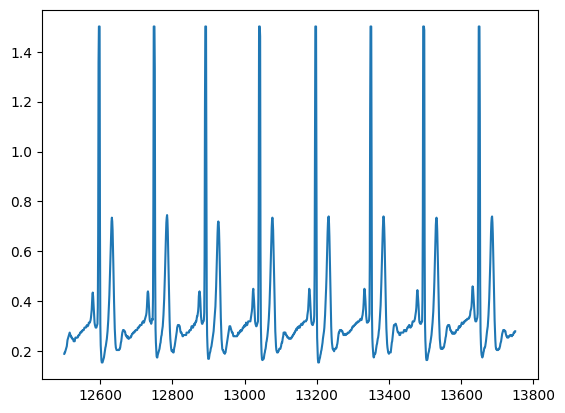

In [127]:
from scipy.signal import find_peaks
import numpy as np

# WITHOUT AF
data=pd.read_csv("/kaggle/input/mimic-perform-af-dataset/mimic_perform_non_af_csv/mimic_perform_non_af_csv/mimic_perform_non_af_002_data.csv")
start=(100*fs)
#signal=data["ECG"].loc[start:start+(5*fs)]
signal=data["ECG"].loc[start:start+fs*10]
peaks, _=find_peaks(signal, height=0.4) # taken from minimum RR interval=0.6
plt.plot(signal.index, signal)
#plt.scatter(np.add(peaks,start), [1]*len(peaks), color='r')
plt.show()

Trying fourier transform

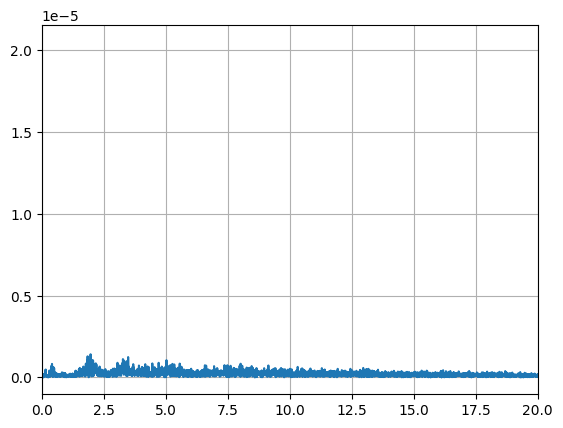

In [83]:
from scipy.fft import fft, fftfreq
import numpy as np
# Number of sample points
N = len(signal)
# sample spacing


yf = fft(signal)
yf = 2.0/N * np.abs(yf[:N//2])
xf = fftfreq(N, 1 / fs)
xf = xf[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim([0,20])
plt.grid()
plt.show()

In [128]:
peaks

array([  79,   97,  132,  232,  249,  285,  375,  392,  427,  524,  541,
        577,  679,  697,  733,  832,  850,  885,  979,  996, 1032, 1132,
       1150, 1186])

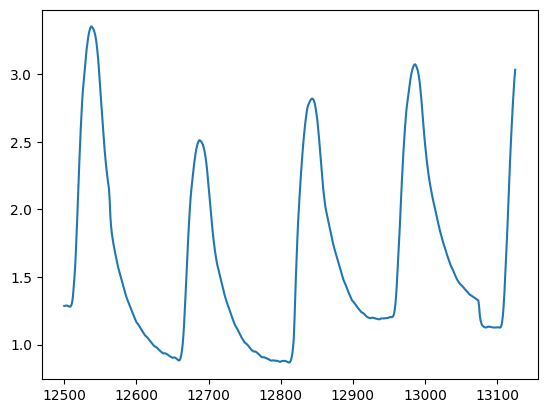

In [129]:
plt.plot(data.index[start:start+(5*fs)+1],data["PPG"].loc[start:start+(5*fs)])

### Arguments can be played with until the graphs below give a smooth curve representing RR interval length
The following graphs represent the change in period (1/heart rate). If big jumps appear, it means peaks were not detected properly, or were over-/under-estimated

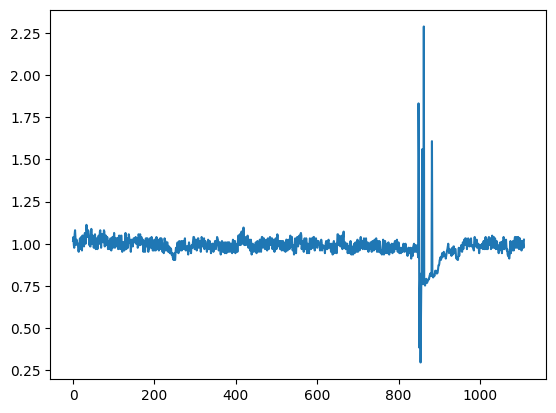

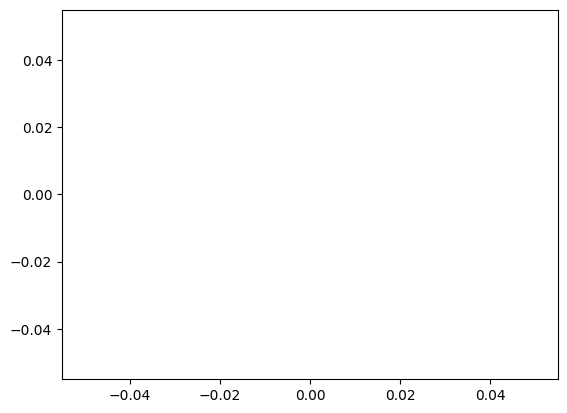

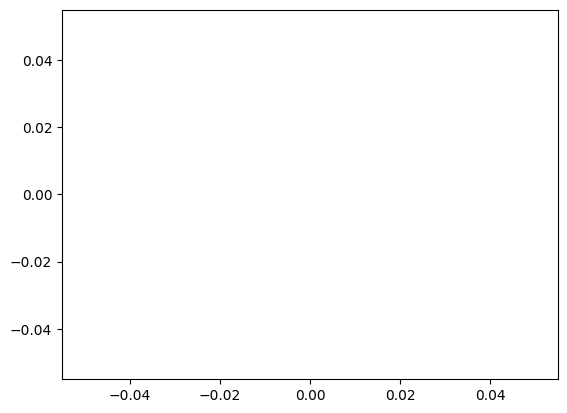

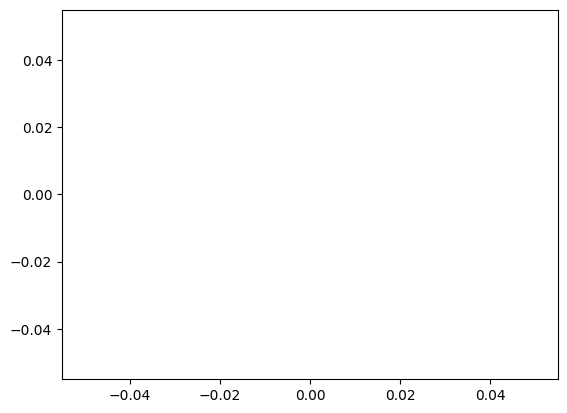

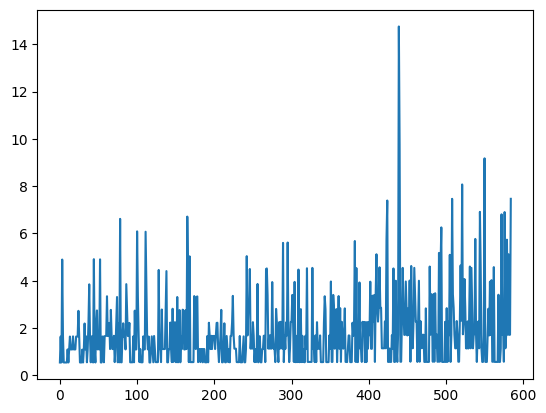

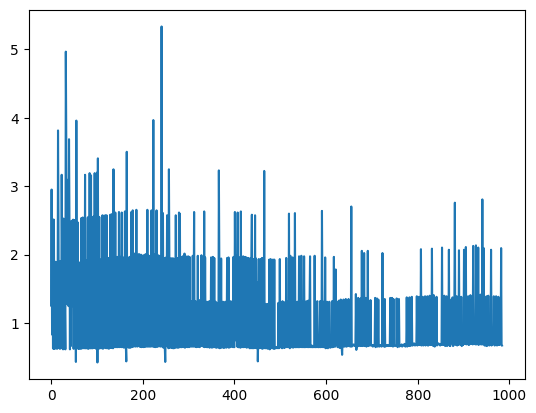

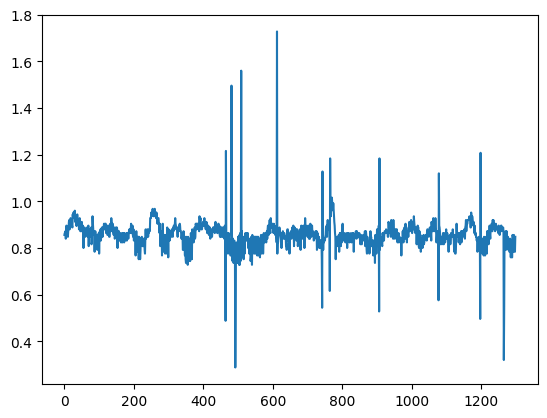

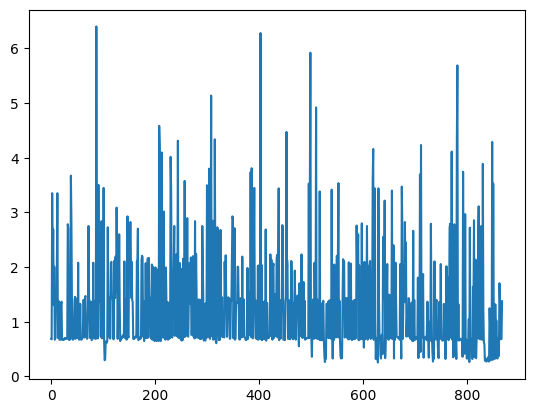

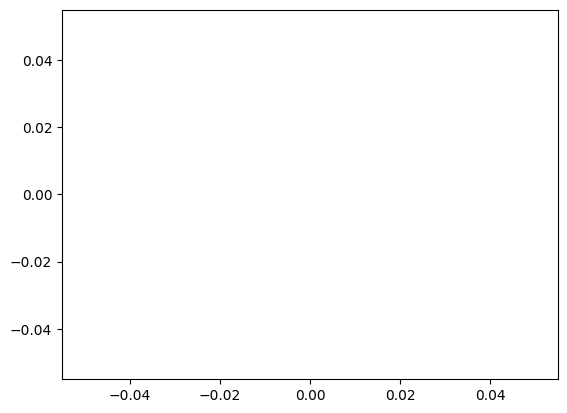

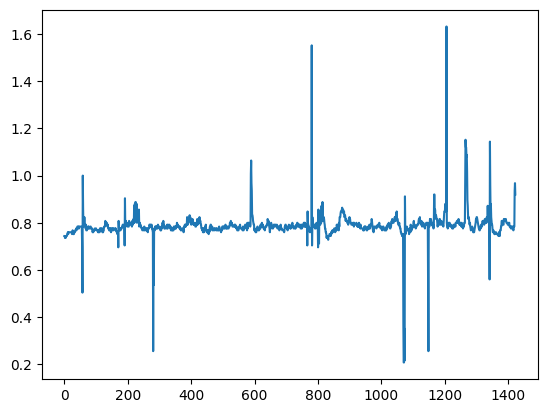

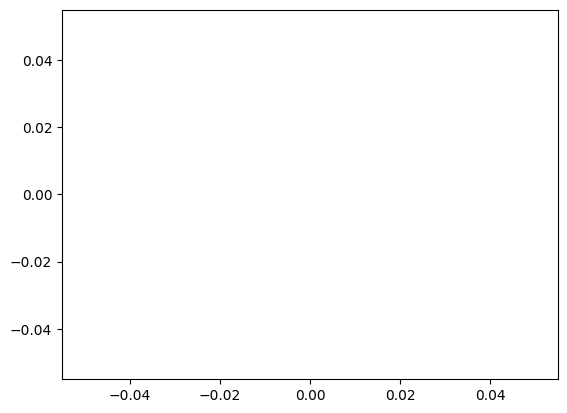

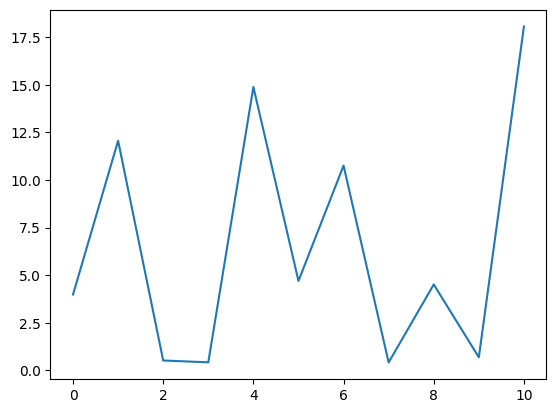

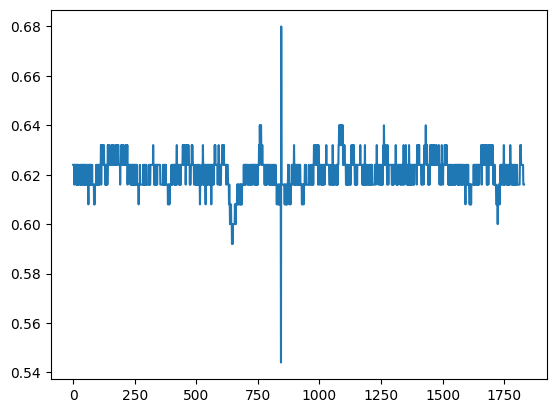

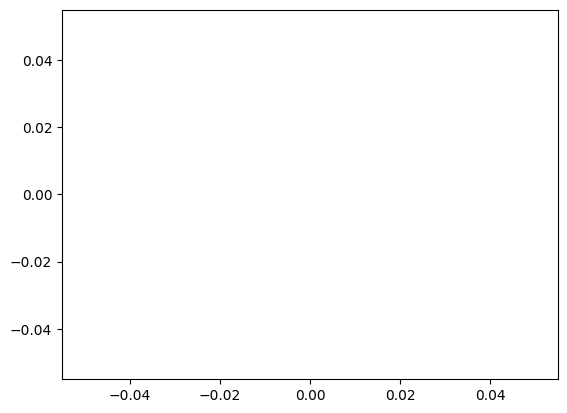

In [22]:
for j in range(1,15):
    data=pd.read_csv("/kaggle/input/mimic-perform-af-dataset/mimic_perform_non_af_csv/mimic_perform_non_af_csv/mimic_perform_non_af_"+str(j).zfill(3)+"_data.csv")
    signal=data["ECG"]
    peaks, _=find_peaks(signal, height=1, threshold=0.001, distance=0.2*fs) # taken from minimum RR interval=0.6
    #peaks, _=find_peaks(signal, height=1, distance=0.5*fs) # taken from minimum RR interval=0.6
    #peaks, _=find_peaks(signal) # taken from minimum RR interval=0.6
    periods=[]
    for i, peak in enumerate(peaks):
        try:
            new_period=(peak/fs)-(peaks[i-1]/fs)
            periods.append(new_period)
        except:
            pass
    #plt.hist(periods[100:])
    #plt.show()
    #print(np.min(periods[100:]))
    #print(np.max(periods[100:]))
    plt.plot(periods[100:])
    plt.show()

### Arguments to be manipulated in find_peaks() function
- Height
- Threshold
- Prominence
- Distance
- Width

# Fourier Transform

Healthy


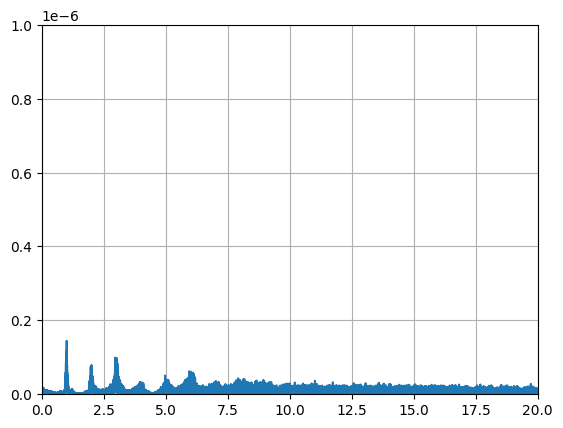

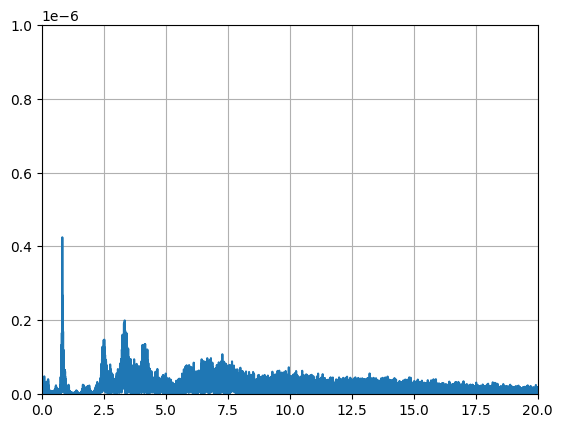

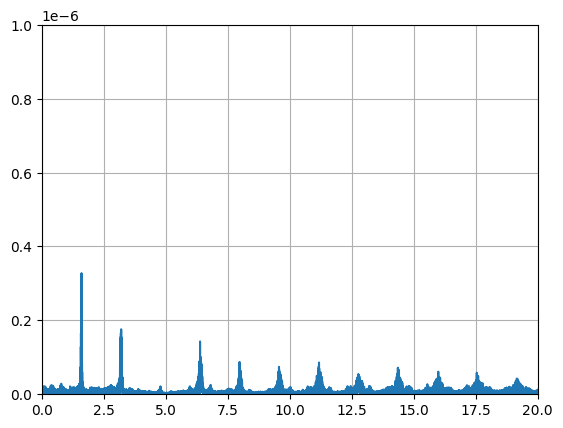

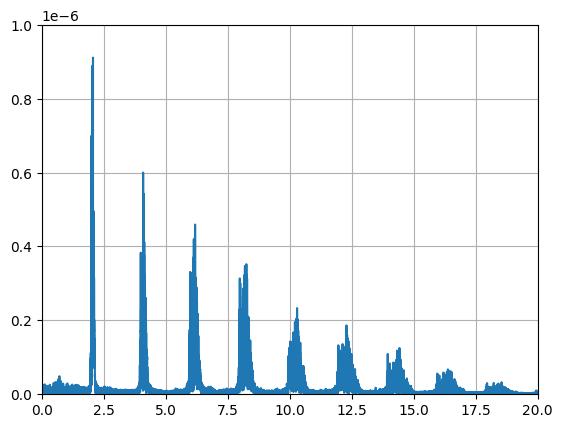

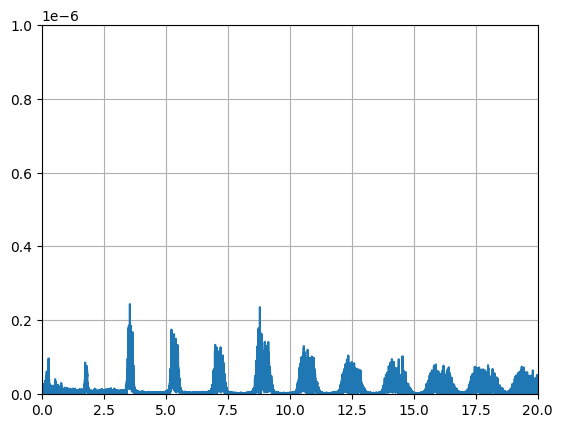

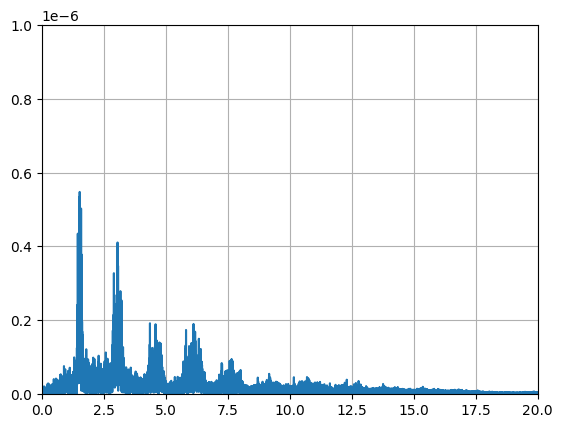

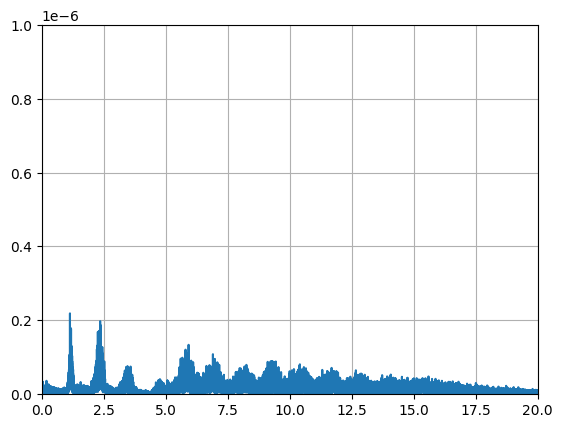

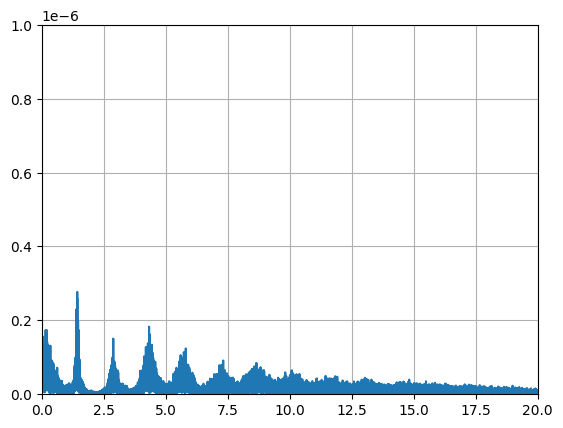

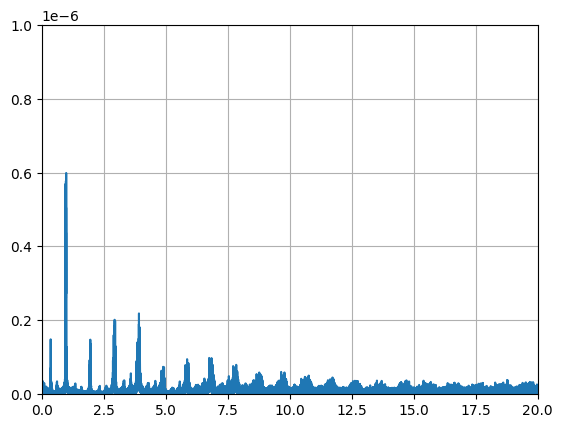

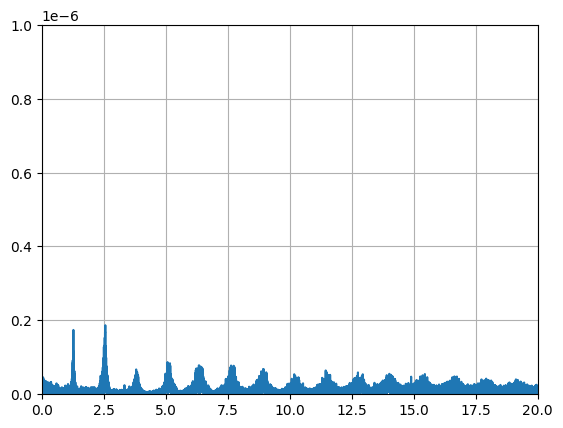

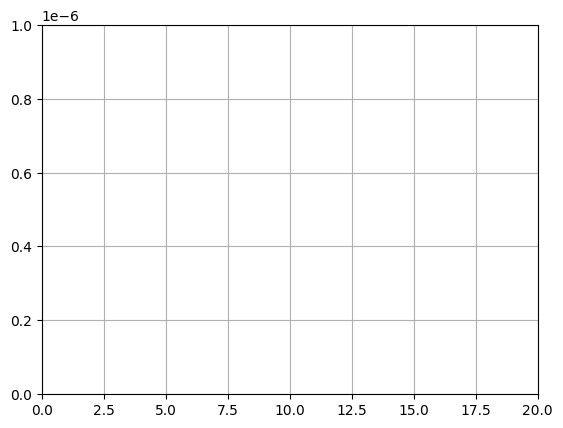

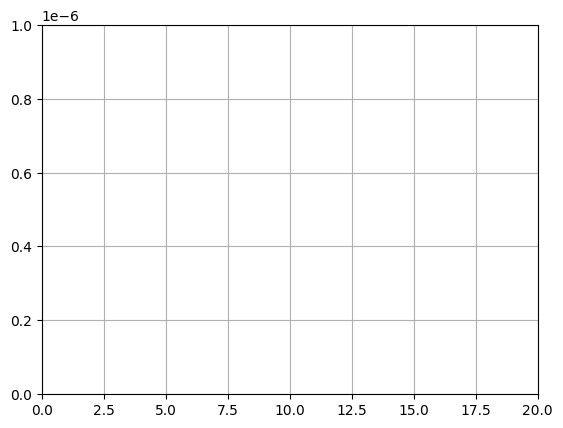

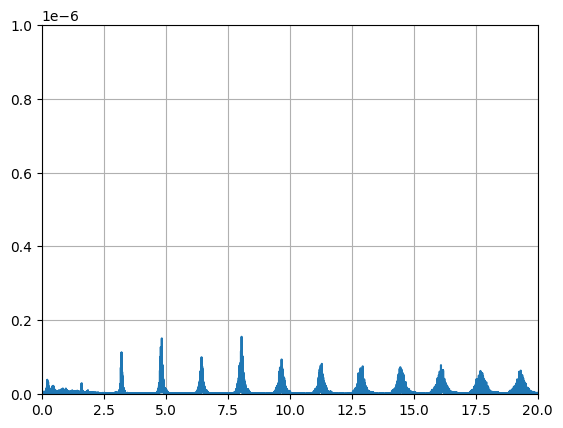

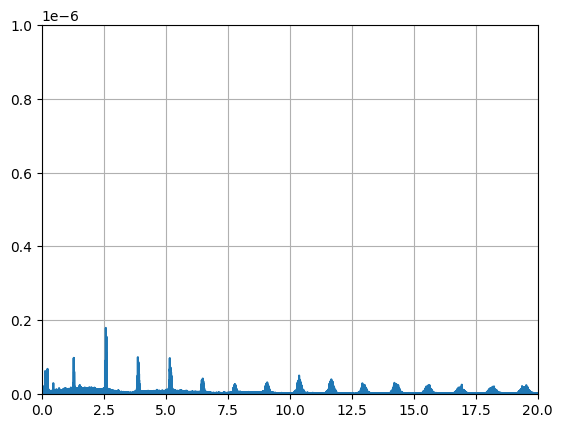

A-Fib


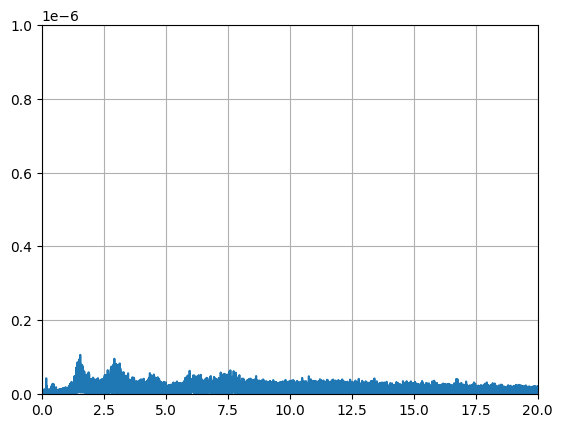

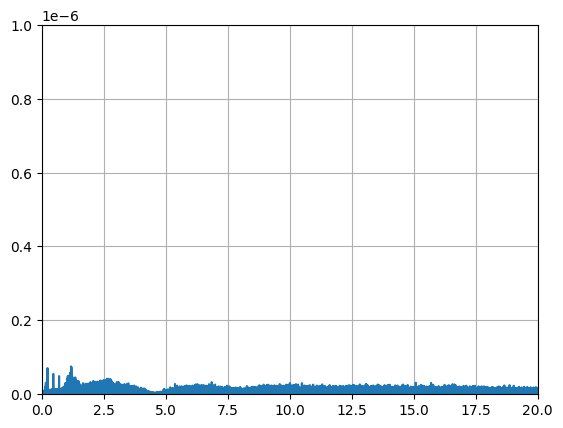

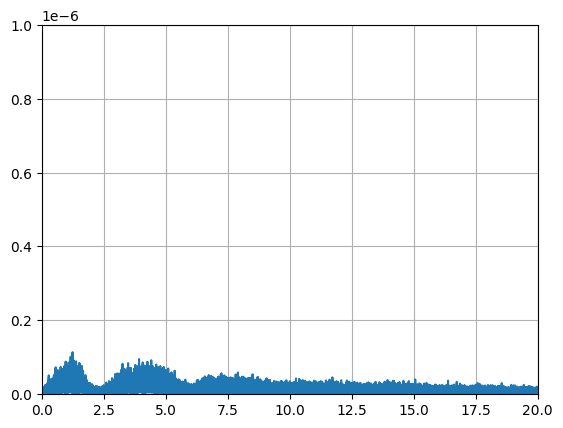

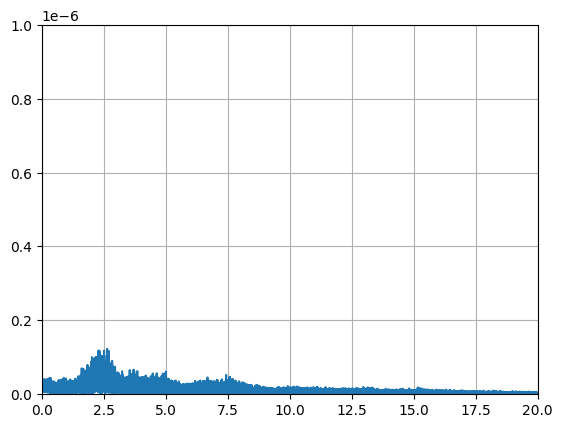

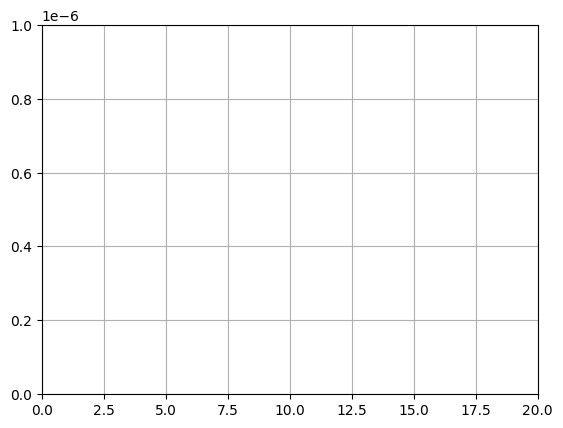

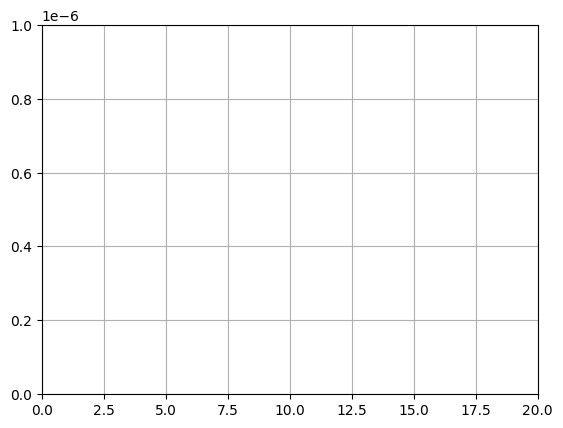

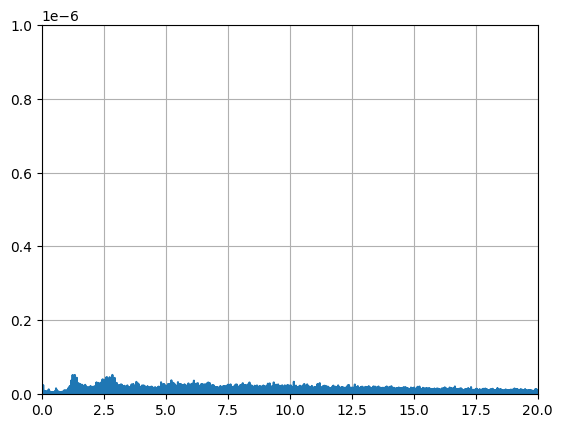

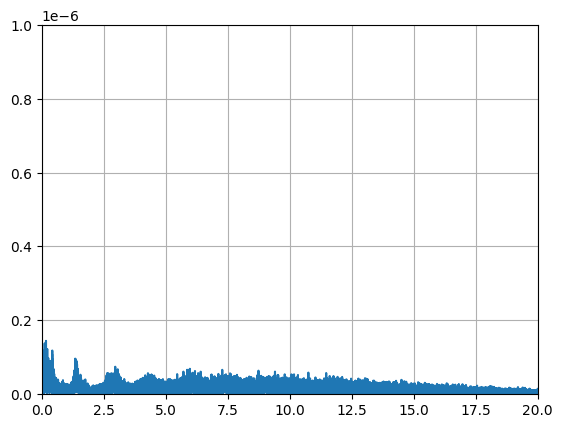

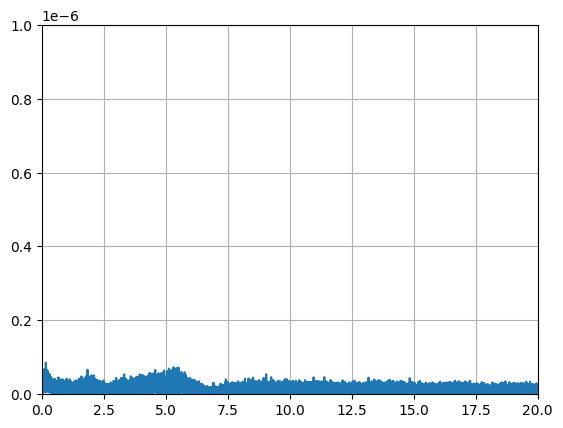

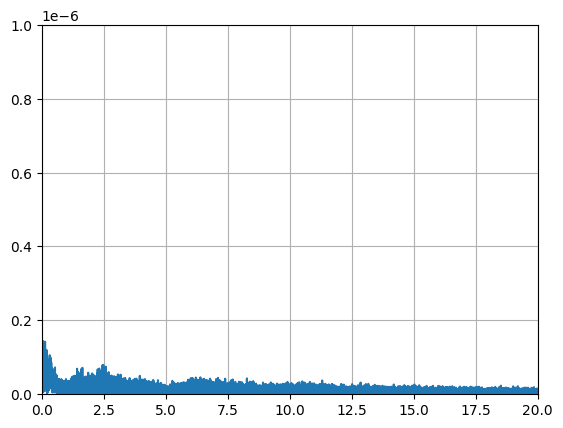

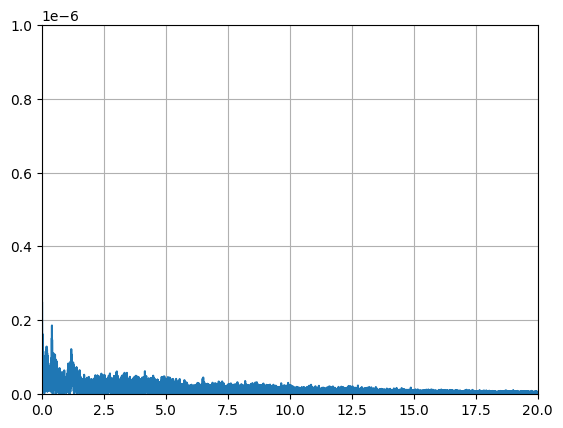

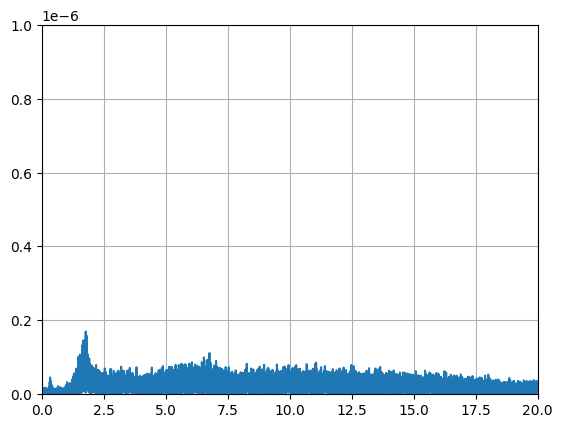

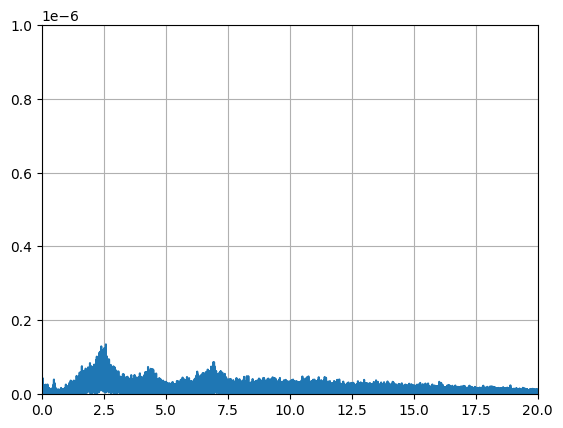

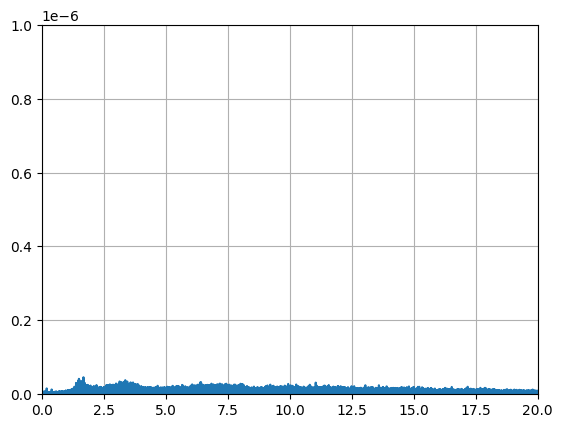

In [91]:
from scipy.fft import fft, fftfreq
import numpy as np
# Number of sample points


print("Healthy")
for j in range(1,15):
    data=pd.read_csv("/kaggle/input/mimic-perform-af-dataset/mimic_perform_non_af_csv/mimic_perform_non_af_csv/mimic_perform_non_af_"+str(j).zfill(3)+"_data.csv")
    signal=data["ECG"]
    yf = fft(signal)
    yf = 2.0/N * np.abs(yf[:N//2])
    xf = fftfreq(N, 1 / fs)
    xf = xf[:N//2]
    import matplotlib.pyplot as plt
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.xlim([0,20])
    plt.ylim([0,1e-6])
    plt.grid()
    plt.show()
print("A-Fib")
for j in range(1,15):
    data=pd.read_csv("/kaggle/input/mimic-perform-af-dataset/mimic_perform_af_csv/mimic_perform_af_csv/mimic_perform_af_"+str(j).zfill(3)+"_data.csv")
    signal=data["ECG"]
    yf = fft(signal)
    yf = 2.0/N * np.abs(yf[:N//2])
    xf = fftfreq(N, 1 / fs)
    xf = xf[:N//2]
    import matplotlib.pyplot as plt
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.xlim([0,20])
    plt.ylim([0,1e-6])
    plt.grid()
    plt.show()

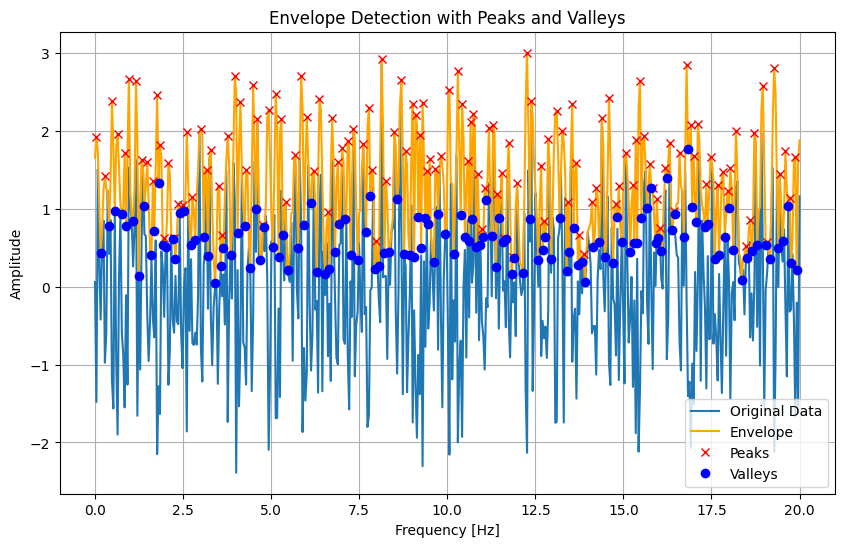

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, find_peaks

# Assuming you already have the data from your plot:
# Replace this with your actual data
x = np.linspace(0, 20, 500)  # Replace this with your frequency axis
y = np.random.normal(size=500)  # Replace this with your actual FFT magnitude data

# Step 1: Compute the envelope using the Hilbert transform
analytic_signal = hilbert(y)
envelope = np.abs(analytic_signal)

# Step 2: Find peaks in the envelope
peaks, _ = find_peaks(envelope)
valleys, _ = find_peaks(-envelope)  # Valleys are negative peaks

# Plotting the original data with envelope, peaks, and valleys
plt.figure(figsize=(10, 6))

# Original FFT magnitude plot
plt.plot(x, y, label="Original Data")

# Envelope of the signal
plt.plot(x, envelope, label="Envelope", color='orange')

# Mark peaks
plt.plot(x[peaks], envelope[peaks], "x", label="Peaks", color='red')

# Mark valleys
plt.plot(x[valleys], envelope[valleys], "o", label="Valleys", color='blue')

plt.title("Envelope Detection with Peaks and Valleys")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


Healthy


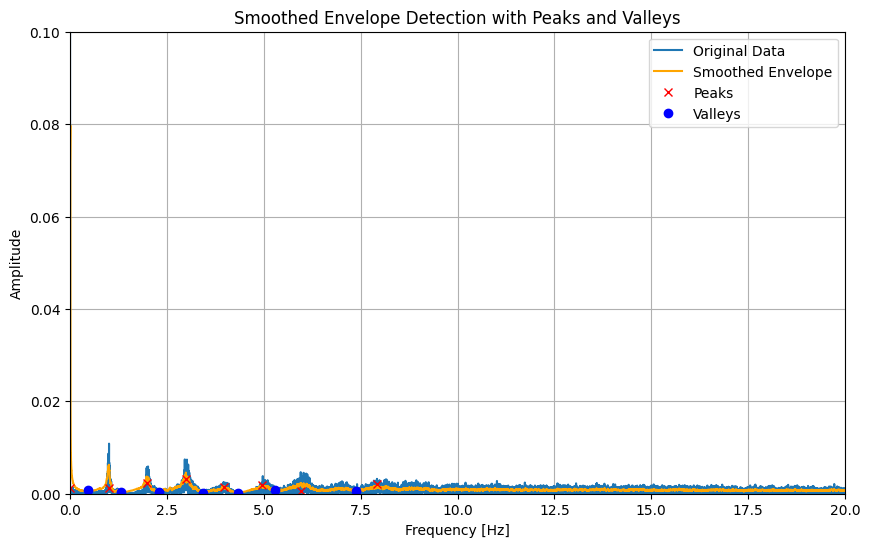

1461.0277777777774


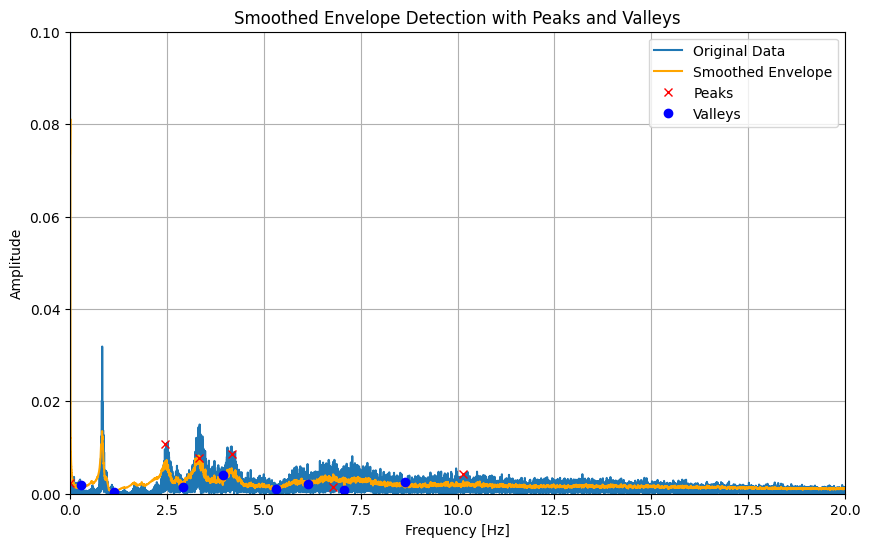

4505.968253968254


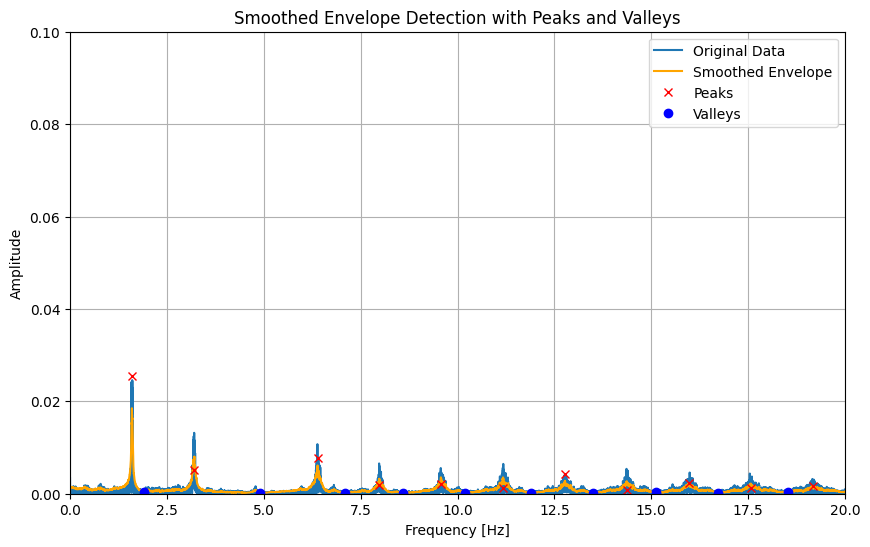

-3112.538461538461


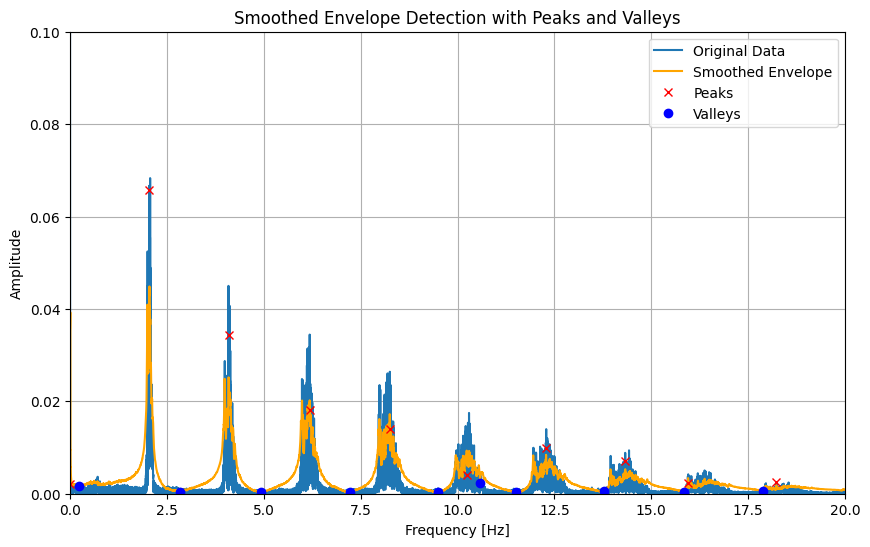

1689.9999999999982


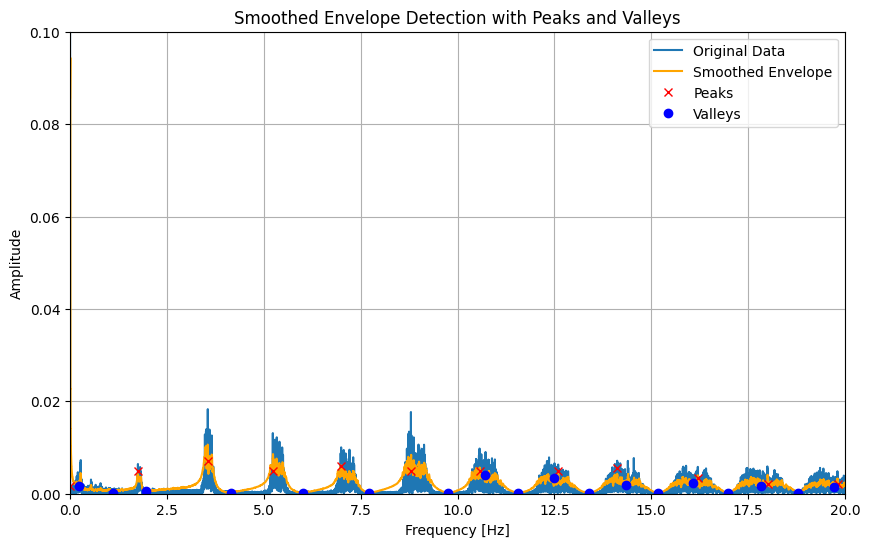

2690.061381074167


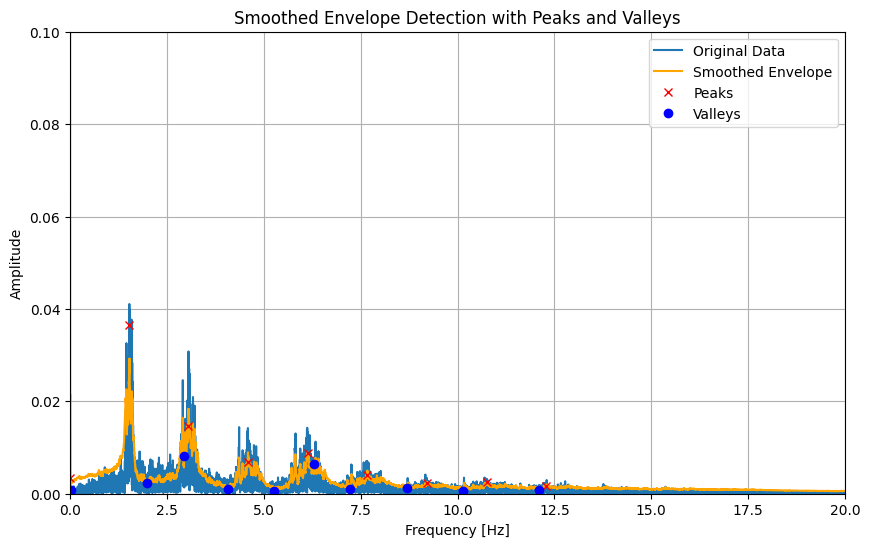

3670.9818181818173


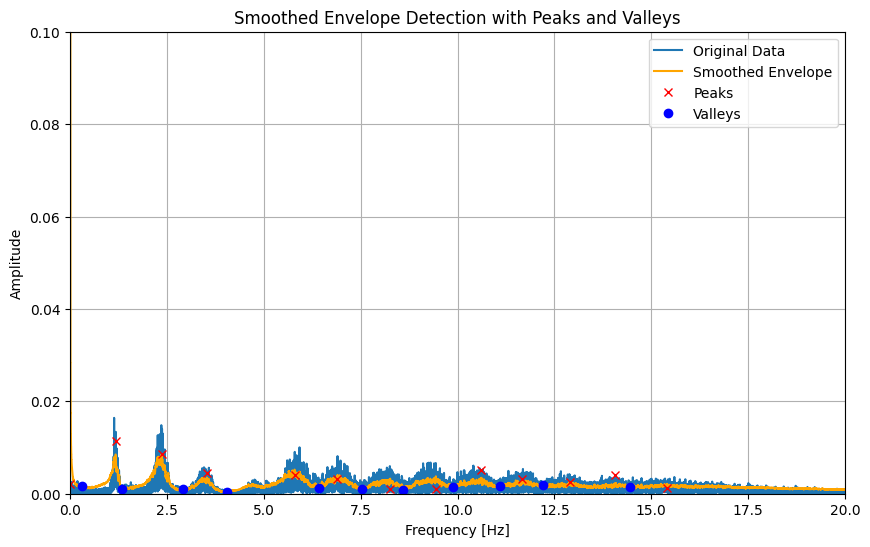

2213.2380952380954


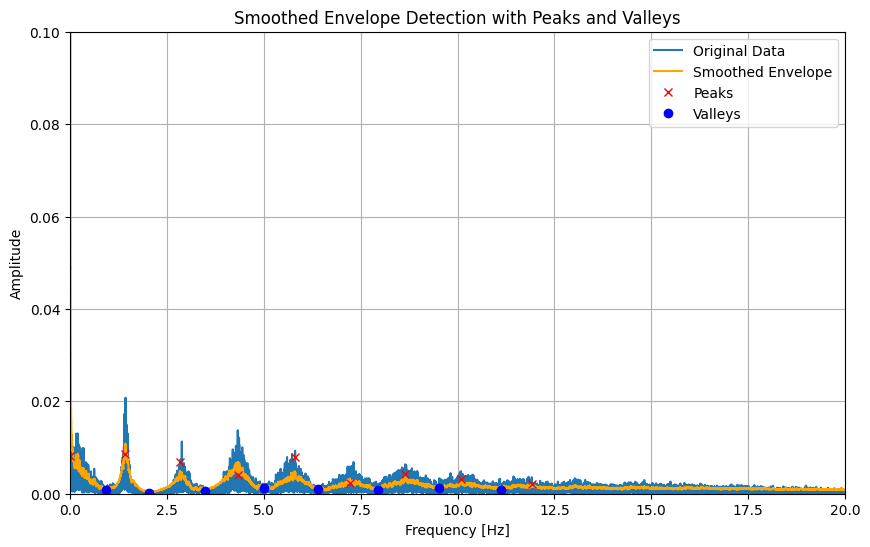

1556.7666666666664


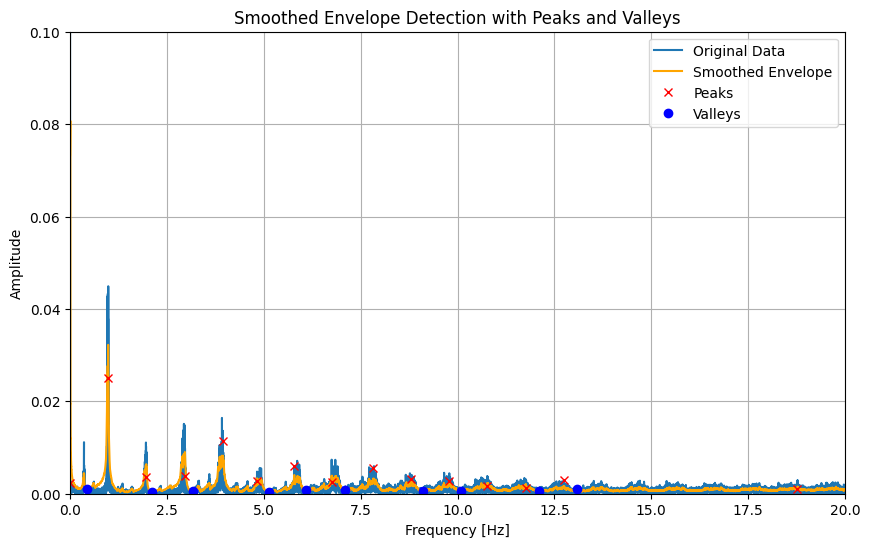

423.19886363636397


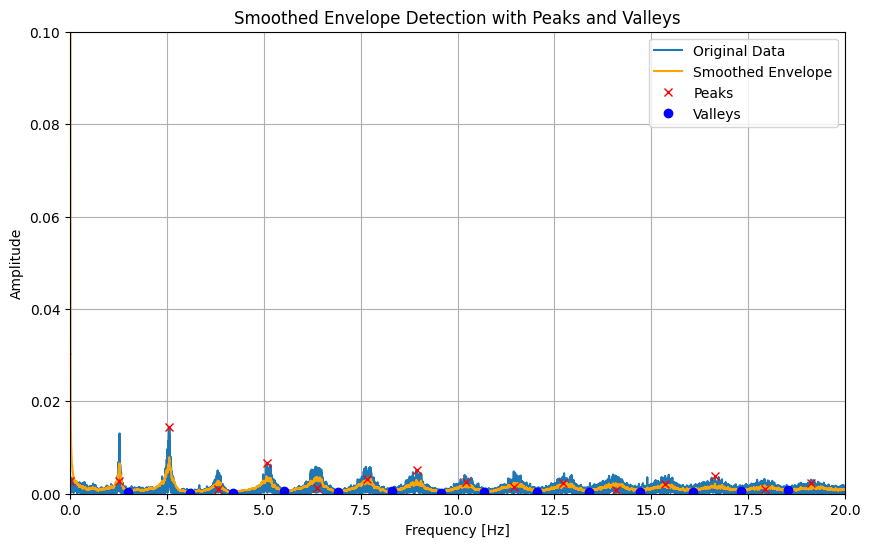

234.12941176470667


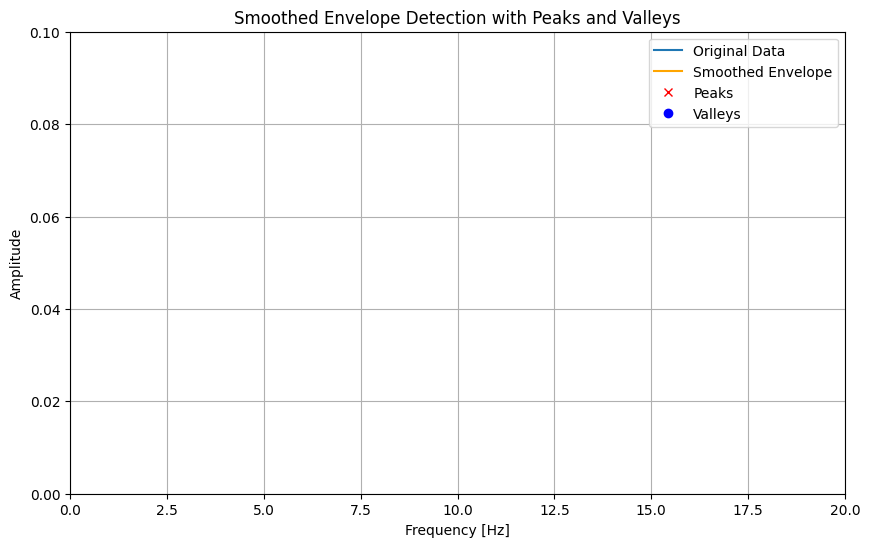

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan


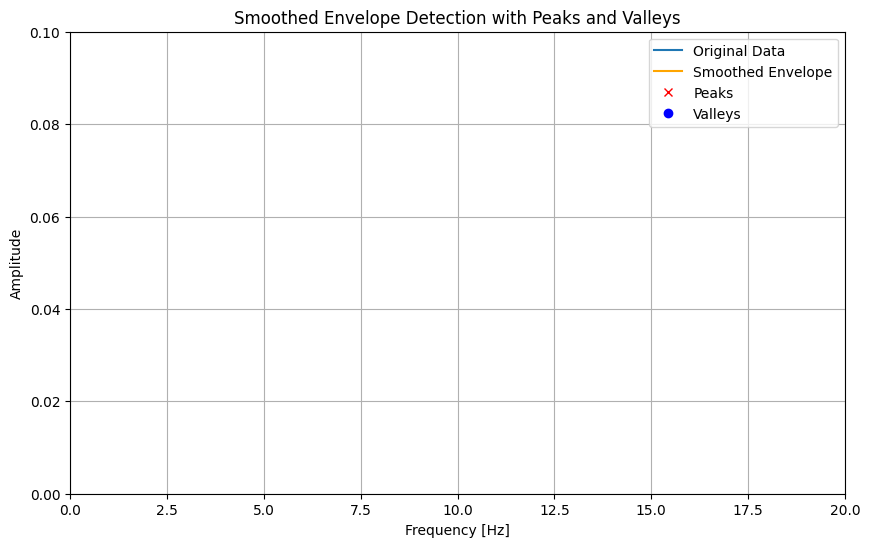

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan


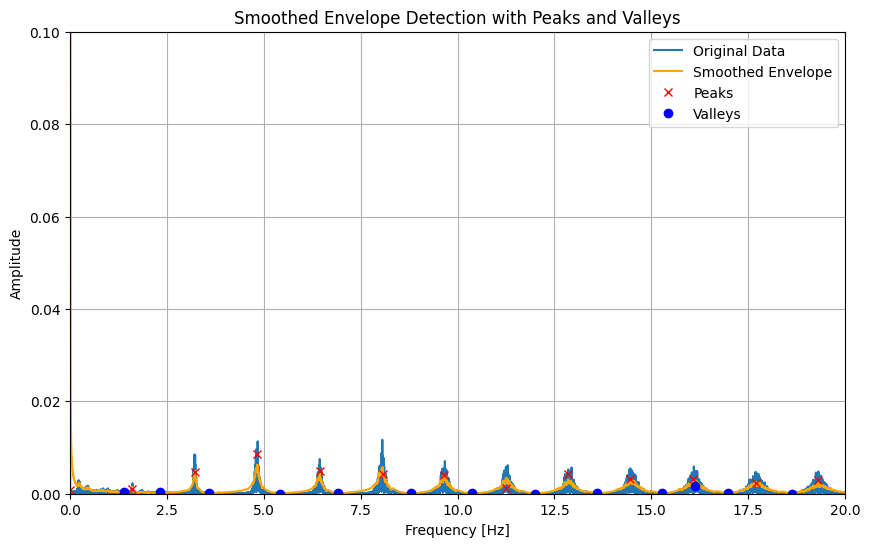

634.6842105263167


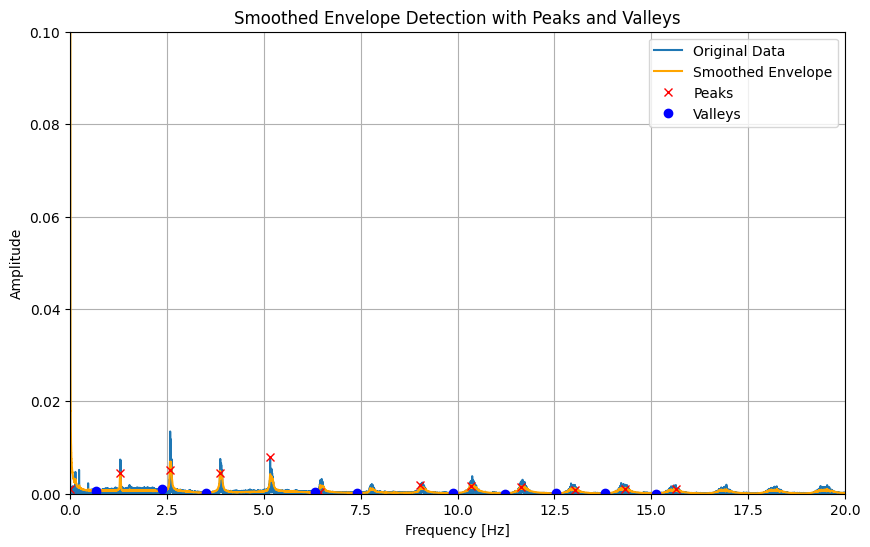

-106.95804195804158
A-Fib


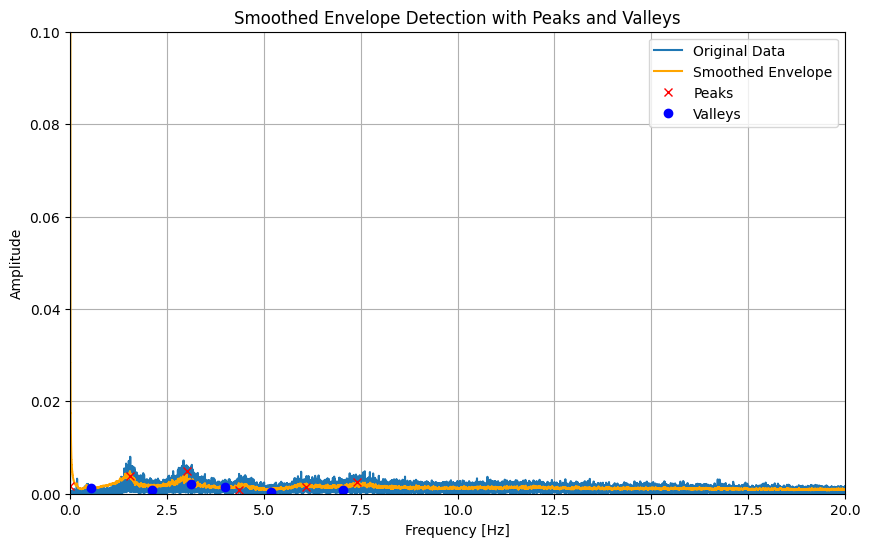

3944.833333333334


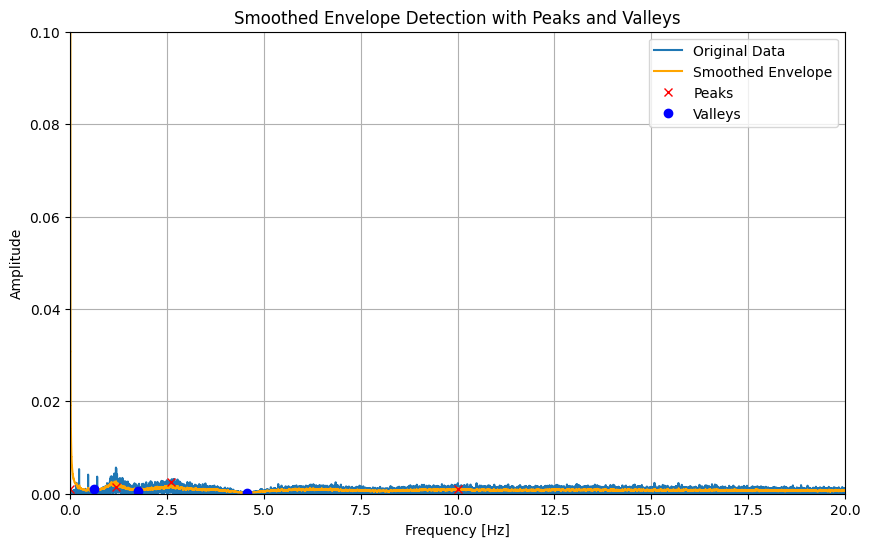

-1998.1666666666642


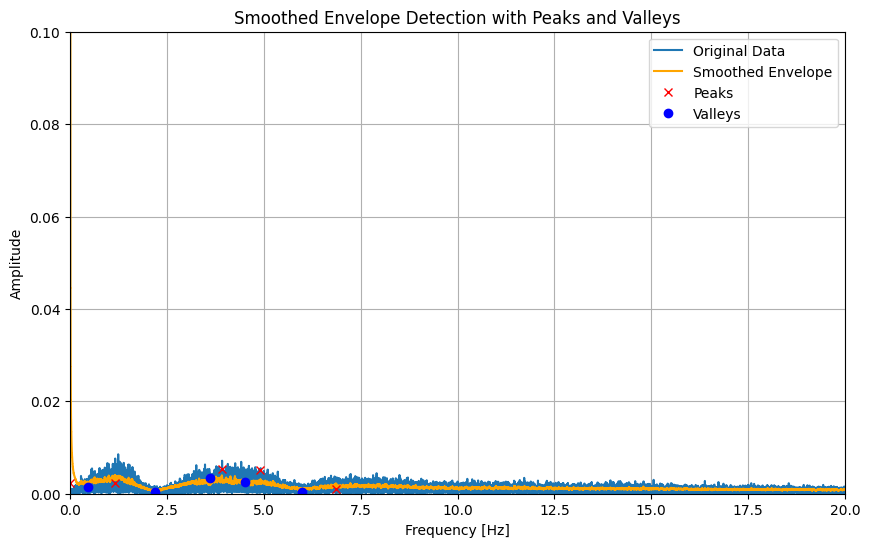

5488.0


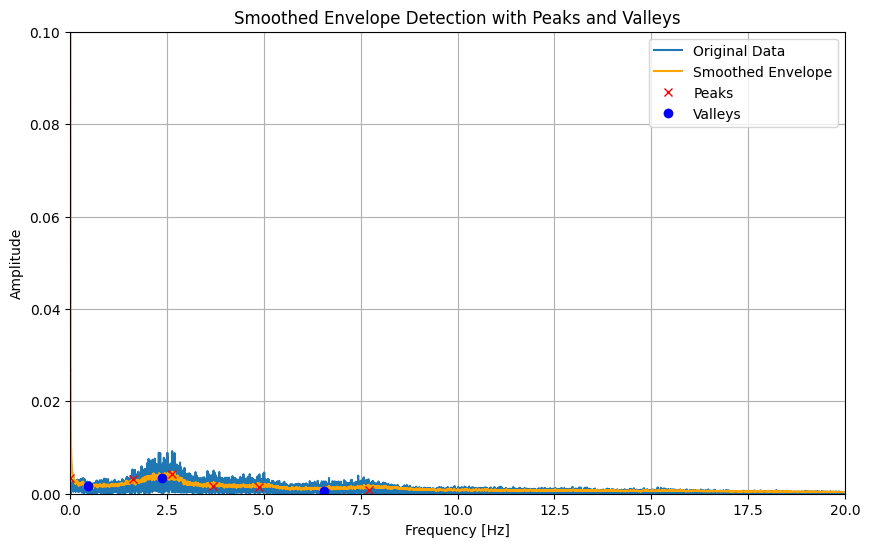

-2698.5


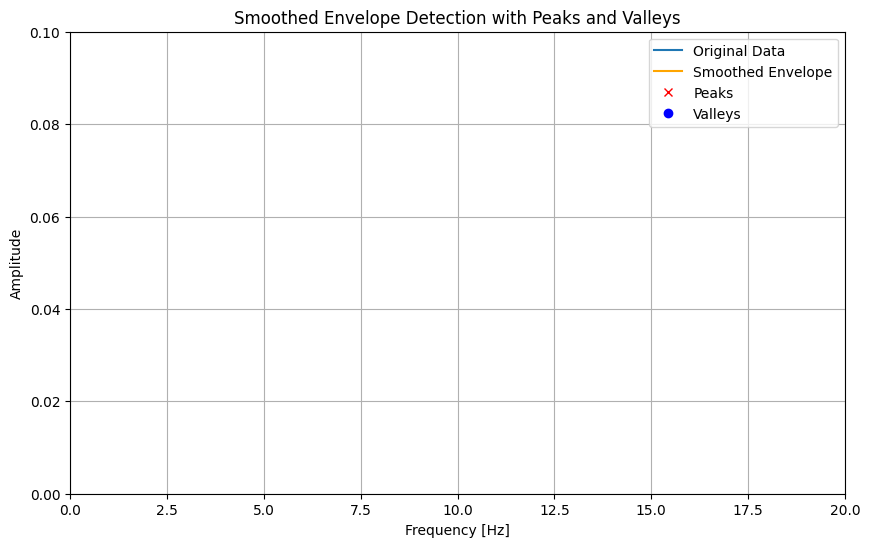

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan


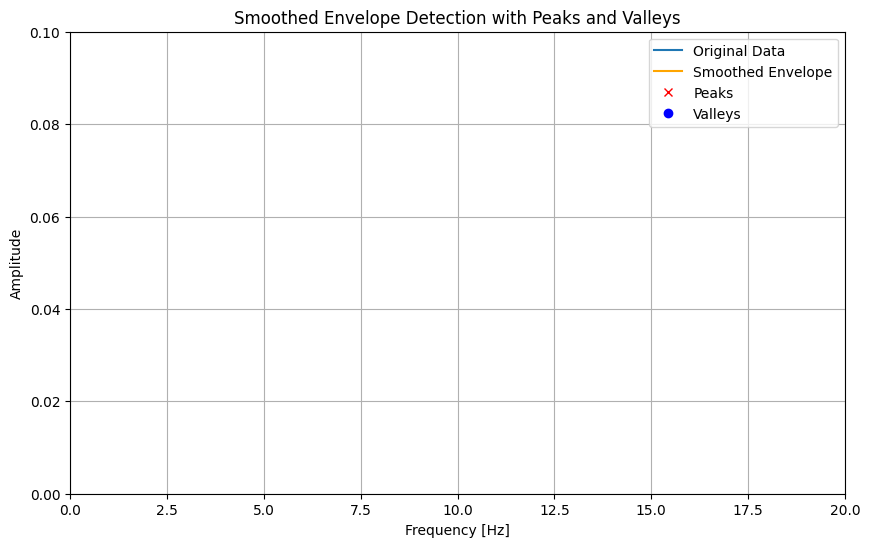

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan


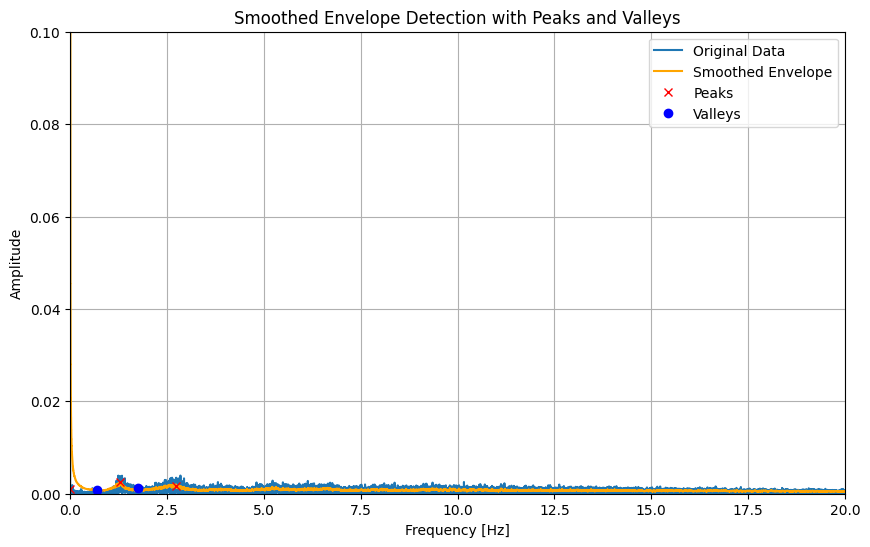

-3497.9166666666642


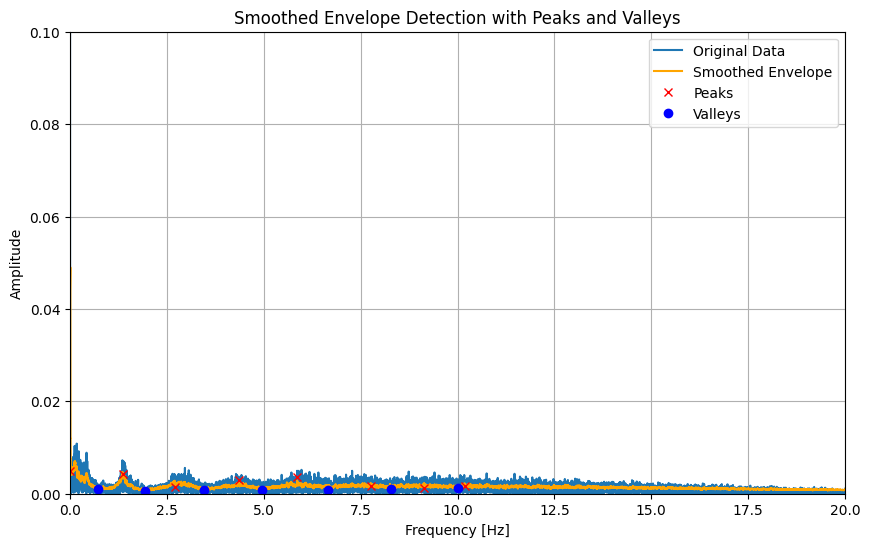

2572.857142857143


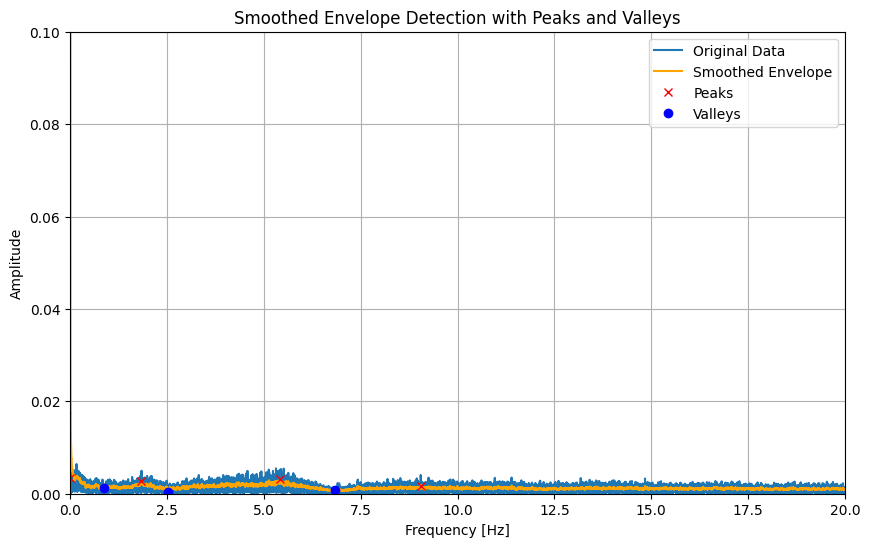

-1497.550000000003


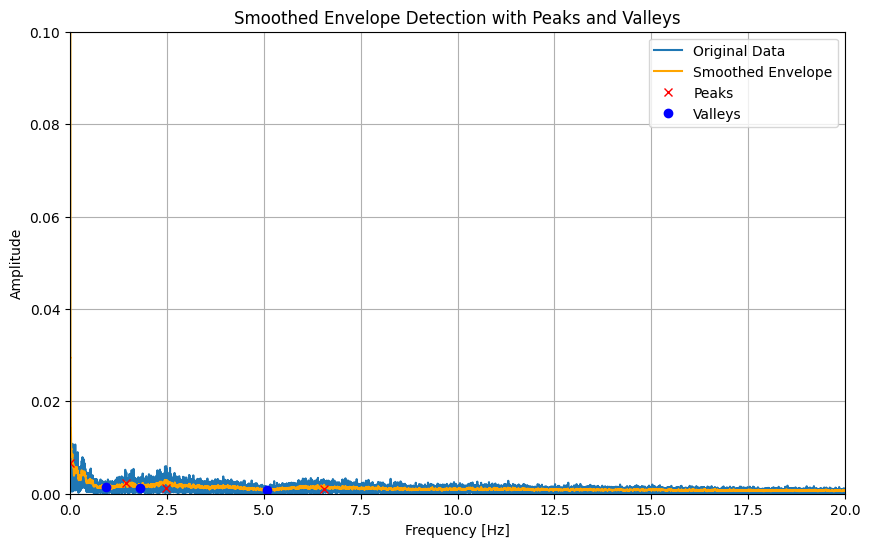

1589.0833333333321


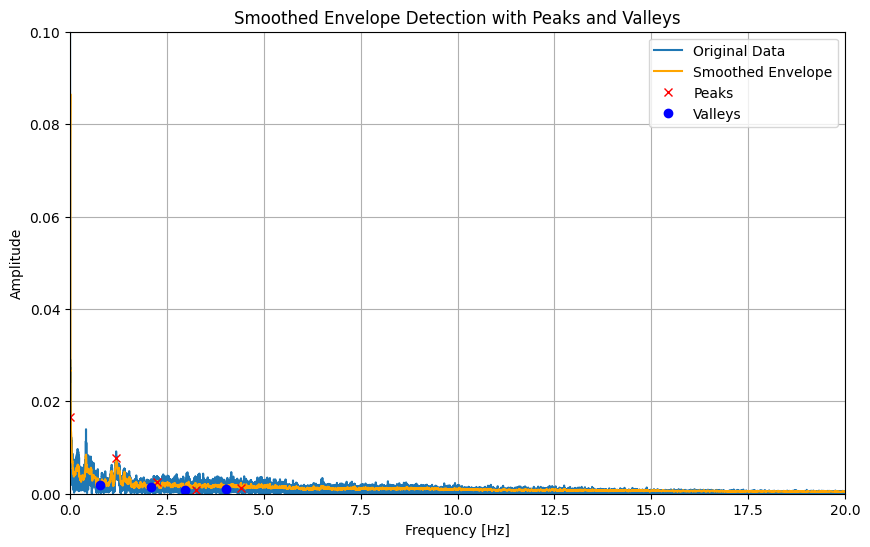

2854.0499999999993


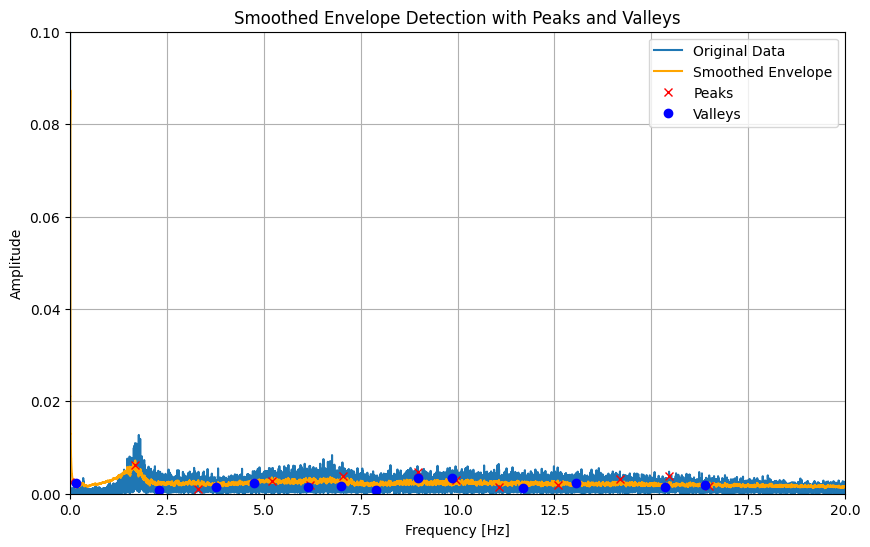

2237.6923076923085


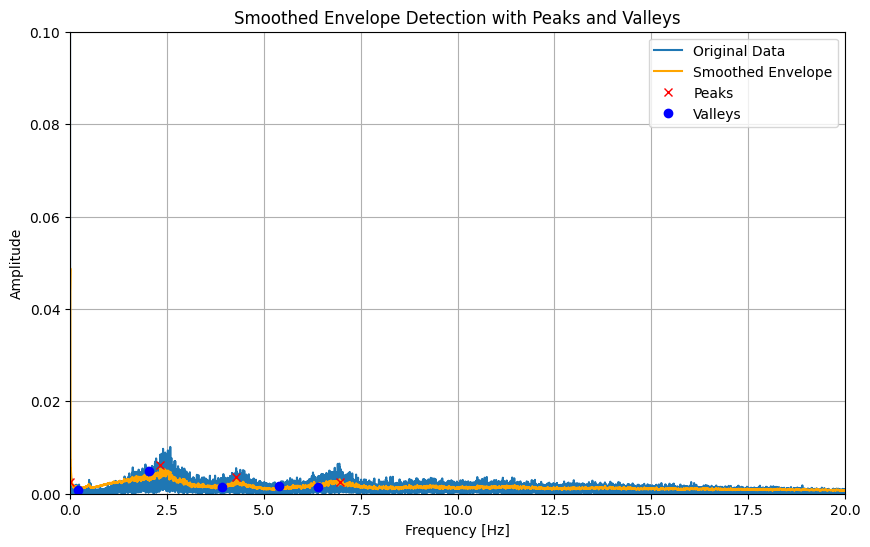

8489.0


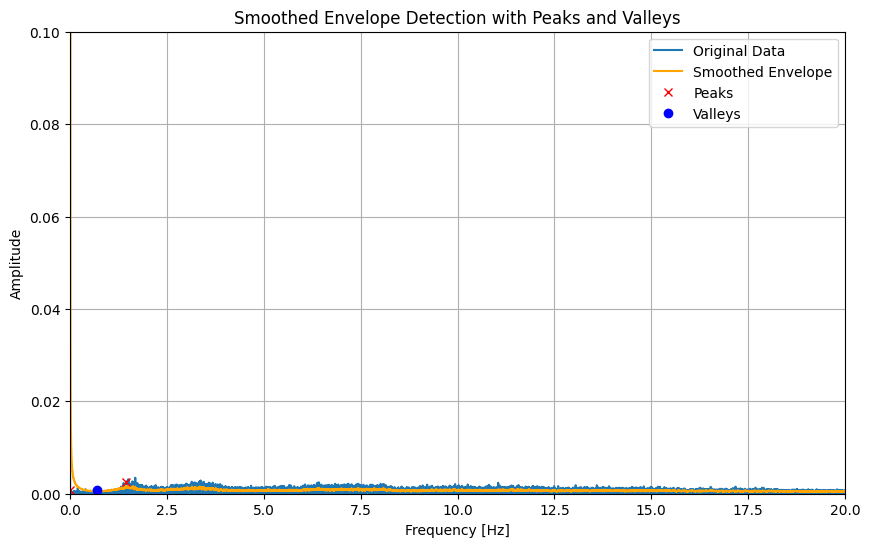

-10462.0


In [121]:
from scipy.fft import fft, fftfreq
import numpy as np
from scipy.signal import hilbert, find_peaks
# Number of sample points


print("Healthy")
# Helper function to apply a moving average filter
def smooth(signal, window_len=10):
    window = np.ones(window_len) / window_len
    return np.convolve(signal, window, mode='same')

for j in range(1, 15):
    data = pd.read_csv("/kaggle/input/mimic-perform-af-dataset/mimic_perform_non_af_csv/mimic_perform_non_af_csv/mimic_perform_non_af_" + str(j).zfill(3) + "_data.csv")
    signal = data["ECG"]
    N = len(signal)
    fs = 125  # Assuming the sampling frequency is 1000 Hz; replace with your actual value
    yf = fft(signal)
    yf = 2.0 / N * np.abs(yf[:N // 2])
    xf = fftfreq(N, 1 / fs)
    xf = xf[:N // 2]

    # Compute the envelope using Hilbert transform
    analytic_signal = hilbert(yf)
    envelope = np.abs(analytic_signal)

    # Smooth the envelope using moving average
    smooth_envelope = smooth(envelope, window_len=20)

    # Find peaks and valleys (optional)
    peaks, _ = find_peaks(smooth_envelope, distance=8*fs, prominence=0.001)
    valleys, _ = find_peaks(-smooth_envelope, distance=8*fs, prominence=0.001)

    # Plotting the original data with smoothed envelope
    plt.figure(figsize=(10, 6))

    # Original FFT magnitude plot
    plt.plot(xf, yf, label="Original Data")

    # Smoothed Envelope of the signal
    plt.plot(xf, smooth_envelope, label="Smoothed Envelope", color='orange')
    plt.plot(xf[peaks], envelope[peaks], "x", label="Peaks", color='red')
    plt.plot(xf[valleys], envelope[valleys], "o", label="Valleys", color='blue')

    plt.title("Smoothed Envelope Detection with Peaks and Valleys")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.xlim([0,20])
    plt.ylim([0,0.1])
    plt.show()
    print(np.mean(peaks)-np.mean(valleys))

print("A-Fib")
for j in range(1,15):
    data=pd.read_csv("/kaggle/input/mimic-perform-af-dataset/mimic_perform_af_csv/mimic_perform_af_csv/mimic_perform_af_"+str(j).zfill(3)+"_data.csv")
    signal=data["ECG"]
    N = len(signal)
    fs = 125  # Assuming the sampling frequency is 1000 Hz; replace with your actual value
    yf = fft(signal)
    yf = 2.0 / N * np.abs(yf[:N // 2])
    xf = fftfreq(N, 1 / fs)
    xf = xf[:N // 2]

    # Compute the envelope using Hilbert transform
    analytic_signal = hilbert(yf)
    envelope = np.abs(analytic_signal)

    # Smooth the envelope using moving average
    smooth_envelope = smooth(envelope, window_len=20)

    # Find peaks and valleys (optional)
    peaks, _ = find_peaks(smooth_envelope, distance=8*fs, prominence=0.001)
    valleys, _ = find_peaks(-smooth_envelope, distance=8*fs, prominence=0.001)

    # Plotting the original data with smoothed envelope
    plt.figure(figsize=(10, 6))

    # Original FFT magnitude plot
    plt.plot(xf, yf, label="Original Data")

    # Smoothed Envelope of the signal
    plt.plot(xf, smooth_envelope, label="Smoothed Envelope", color='orange')
    plt.plot(xf[peaks], envelope[peaks], "x", label="Peaks", color='red')
    plt.plot(xf[valleys], envelope[valleys], "o", label="Valleys", color='blue')

    plt.title("Smoothed Envelope Detection with Peaks and Valleys")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.xlim([0,20])
    plt.ylim([0,0.1])
    plt.show()
    print(np.mean(peaks[1:])-np.mean(valleys[1:]))